# Makine Öğrenmesi ile Yolcu Sayısı Tahmini

### İş PROBLEMİ
Türk Hava Yolları uçuşlarda bulunan sezonluk rezervasyonlu yolcu sayısını tahmin edebilmek için bir makine öğrenmesi regresyon modeli kurulmasını istemektedir.

### Veri Seti Hikayesi
Türk Hava Yollarına ait bu veri seti 1 aktarmalı (2 leg) sezonluk origin & destination bazında uçuş bilgilerini içermektedir.

17 Değişken 18.1173 Gözlem 12 KB

- CARRIER Taşıyıcı firmanın ikili kodudur. 2 leg için de taşıyıcı firma aynıdır.
- AIRCRAFT_TYPE Uçak tipi bilgisidir.
- OND_SELL_CLASS En uzun legin satış sınıfıdır.
- LEG1_SELL_CLASS 1.leg in satış sınıfıdır.
- OND_CABIN_CLASS En uzun leg in kabin sınıfıdır.
- LEG1_CABIN_CLASS 1.leg in kabin sınıfıdır.
- HUB 1.leg uçuşundan 2.leg uçuşuna aktarma yapılan havalimanının IATA kodlarını içerir.
- DETUR_FACTOR Bir yolcunun uçmak istediği noktaya direkt uçmak yerine bağlantılı uçması durumunda yolunu ne kadar uzattığını ifade eden bir orandır.
- CONNECTION_TIME 1.leg uçuşundan 2.leg uçuşuna aktarma için beklenen süreyi dakika cinsinden ifade eder.
- PSGR_COUNT Toplam rezervasyonlu yolcu sayısıdır.
- LEG1_DEP_FULL 1. Leg’in kalkış tarih ve saatidir.
- LEG1_ARR_FULL 1. Leg’in varış tarih ve saatidir.
- LEG2_DEP_FULL 2. Leg’in kalkış tarih ve saatidir.
- LEG2_ARR_FULL 2. Leg’in varış tarih ve saatidir.
- LEG1_DURATION 1. Leg’in uçuş süresi.
- LEG2_DURATION 2. Leg’in uçuş süresi.
- FLIGHT_DURATION  1. Leg’in kalkış saatinden 2. Leg’in iniş saatine kadar geçen zaman.

Adım1: thyTrain.csv dosyasını okutunuz.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import LocalOutlierFactor
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
import warnings
warnings.simplefilter(action="ignore")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df = pd.read_csv("thyTrain.csv")
df.head()


,CARRIER,AIRCRAFT_TYPE,OND_SELL_CLASS,LEG1_SELL_CLASS,OND_CABIN_CLASS,LEG1_CABIN_CLASS,HUB,DETUR_FACTOR,CONNECTION_TIME,PSGR_COUNT,LEG1_DEP_FULL,LEG1_ARR_FULL,LEG2_DEP_FULL,LEG2_ARR_FULL,LEG1_DURATION,LEG2_DURATION,FLIGHT_DURATION
0,3K,77W,T,T,Q,Q,DXB,1.00,200,1,2018-03-13 16:30:00,2018-03-13 18:20:00,2018-03-13 21:40:00,2018-03-14 02:35:00,01:50:00,04:55:00,10:05:00
1,SV,330,T,T,Q,Q,JED,1.04,120,1,2018-02-11 21:25:00,2018-02-11 23:10:00,2018-02-12 01:10:00,2018-02-12 09:50:00,01:45:00,08:40:00,12:25:00
2,SK,73W,T,T,Q,Q,OSL,1.02,45,1,2018-11-19 05:10:00,2018-11-19 06:00:00,2018-11-19 06:45:00,2018-11-19 08:40:00,00:50:00,01:55:00,03:30:00
3,SN,319,L,L,Q,Q,BRU,1.44,140,1,2018-09-11 04:50:00,2018-09-11 06:35:00,2018-09-11 08:55:00,2018-09-11 15:05:00,01:45:00,06:10:00,10:15:00
4,3K,32A,K,K,Q,Y,ALG,1.28,265,1,2018-03-18 08:25:00,2018-03-18 09:45:00,2018-03-18 14:10:00,2018-03-18 20:40:00,01:20:00,06:30:00,12:15:00


In [2]:
df.shape

(181173, 17)

Adım2: Target değişkeninin (PSGR_COUNT) standart sapma ve ortalama bilgilerini getiriniz.

In [3]:
df["PSGR_COUNT"].agg(["std","mean"])

std    3.07
mean   2.12
Name: PSGR_COUNT, dtype: float64

Adım3: Target değişkenini büyükten küçüğe sıralayıp veri setinin ilk 10 satırını getiriniz.

In [4]:
df.sort_values("PSGR_COUNT",ascending=False).head(10)

,CARRIER,AIRCRAFT_TYPE,OND_SELL_CLASS,LEG1_SELL_CLASS,OND_CABIN_CLASS,LEG1_CABIN_CLASS,HUB,DETUR_FACTOR,CONNECTION_TIME,PSGR_COUNT,LEG1_DEP_FULL,LEG1_ARR_FULL,LEG2_DEP_FULL,LEG2_ARR_FULL,LEG1_DURATION,LEG2_DURATION,FLIGHT_DURATION
52202,LX,321,L,L,Q,Q,ZRH,1.00,75,190,2018-10-28 08:45:00,2018-10-28 10:40:00,2018-10-28 11:55:00,2018-10-28 23:55:00,01:55:00,12:00:00,15:10:00
15850,LO,7M8,V,V,Q,Q,WAW,1.08,130,153,2018-09-27 07:00:00,2018-09-27 12:15:00,2018-09-27 14:25:00,2018-09-27 15:20:00,05:15:00,00:55:00,08:20:00
101215,3Y,388,G,G,Z,Z,AUH,1.25,50,143,2018-06-29 19:45:00,2018-06-30 03:00:00,2018-06-30 03:50:00,2018-06-30 11:40:00,07:15:00,07:50:00,15:55:00
50544,3K,77W,G,G,Q,Q,DXB,1.01,100,141,2018-01-14 15:55:00,2018-01-14 19:10:00,2018-01-14 20:50:00,2018-01-15 00:40:00,03:15:00,03:50:00,08:45:00
27634,3K,77W,G,G,Q,Q,DXB,1.00,95,138,2018-05-07 17:40:00,2018-05-08 01:40:00,2018-05-08 03:15:00,2018-05-08 08:05:00,08:00:00,04:50:00,14:25:00
87194,5Z,73H,Q,Q,Q,Q,DXB,1.19,180,119,2018-10-16 06:10:00,2018-10-16 09:10:00,2018-10-16 12:10:00,2018-10-16 14:50:00,03:00:00,02:40:00,08:40:00
12853,KU,320,Y,Y,Y,Y,KWI,1.05,61,115,2018-07-10 15:50:00,2018-07-10 17:15:00,2018-07-10 18:16:00,2018-07-10 22:15:00,01:25:00,03:59:00,06:25:00
68182,1K,333,U,U,Q,Q,IST,1.01,40,111,2018-03-16 08:20:00,2018-03-16 10:35:00,2018-03-16 11:15:00,2018-03-17 00:50:00,02:15:00,13:35:00,16:30:00
140720,3K,77W,G,G,Q,Q,DXB,1.07,145,111,2018-11-11 08:30:00,2018-11-11 10:45:00,2018-11-11 13:10:00,2018-11-11 16:05:00,02:15:00,02:55:00,07:35:00
144697,78,744,G,G,Q,Q,LHR,1.07,150,109,2018-10-20 17:30:00,2018-10-21 05:30:00,2018-10-21 08:00:00,2018-10-21 10:55:00,12:00:00,02:55:00,17:25:00


Adım4: LEG1_DEP_FULL, LEG1_ARR_FULL, LEG2_DEP_FULL, LEG2_ARR_FULL değişkenlerinin min ve max değerlerini getiriniz.

In [5]:
df[["LEG1_DEP_FULL","LEG1_ARR_FULL","LEG2_DEP_FULL","LEG2_ARR_FULL"]].agg(["min","max"])

,LEG1_DEP_FULL,LEG1_ARR_FULL,LEG2_DEP_FULL,LEG2_ARR_FULL
min,2018-01-01 00:00:00,2018-01-01 00:50:00,2018-01-01 01:15:00,2018-01-01 04:45:00
max,2018-12-31 23:45:00,2019-01-01 10:35:00,2019-01-02 00:15:00,2019-01-02 11:25:00


Adım5: Her değişkendeki boş değer sayısını yazdırınız ve boş değer bulunan gözlemleri o değişkenin modu ile doldurunuz.

In [6]:
df.isnull().sum()

CARRIER               0
AIRCRAFT_TYPE       716
OND_SELL_CLASS        0
LEG1_SELL_CLASS       0
OND_CABIN_CLASS       0
LEG1_CABIN_CLASS      0
HUB                   0
DETUR_FACTOR          0
CONNECTION_TIME       0
PSGR_COUNT            0
LEG1_DEP_FULL         0
LEG1_ARR_FULL         0
LEG2_DEP_FULL         0
LEG2_ARR_FULL         0
LEG1_DURATION         0
LEG2_DURATION         0
FLIGHT_DURATION       0
dtype: int64

In [7]:
df["AIRCRAFT_TYPE"].fillna(df["AIRCRAFT_TYPE"].mode()[0], inplace=True)

Adım 6: Aşağıda belirtilen değişkenleri oluşturunuz.


LEG1_DEP_FULL değişkeninin ay bilgisi -> LEG1_DEP_MONTH

LEG1_DEP_FULL değişkeninin saat bilgisi -> LEG1_DEP_HOUR

LEG1_ARR_FULL değişkeninin ay bilgisi -> LEG1_ARR_MONTH

LEG1_ARR_FULL değişkeninin saat bilgisi -> LEG1_ARR_HOUR

LEG2_DEP_FULL değişkeninin ay bilgisi -> LEG2_DEP_MONTH

LEG2_DEP_FULL değişkeninin saat bilgisi -> LEG2_DEP_HOUR

LEG2_ARR_FULL değişkeninin ay bilgisi -> LEG2_ARR_MONTH

LEG2_ARR_FULL değişkeninin saat bilgisi ->LEG2_ARR_HOUR

LEG1_DEP_FULL değişkeninin haftanın günü bilgisi (Pazartesi, Salı,...) -> LEG1_DEP_DAY

LEG1_ARR_FULL değişkeninin haftanın günü bilgisi (Pazartesi, Salı,...) -> LEG1_ARR_DAY

LEG2_DEP_FULL değişkeninin haftanın günü bilgisi (Pazartesi, Salı,...) -> LEG2_DEP_DAY

LEG2_ARR_FULL değişkeninin haftanın günü bilgisi (Pazartesi, Salı,...) -> LEG2_ARR_DAY

LEG1_DURATION değişkenini dakika cinsine çeviriniz. (to_timedelta fonksiyonunu kullanarak zamana çevirip daha sonra dakikaya çevirme işlemini yapın.) (01:50 -> 110) -> LEG1_DURATION_MINUTES

LEG2_DURATION değişkenini dakika cinsine çeviriniz. (01:50 -> 110) -> LEG2_DURATION_MINUTES

FLIGHT_DURATION değişkenini dakika cinsine çeviriniz. (01:50 -> 110) -> FLIGHT_DURATION_MINUTES

LEG1_DURATION ile LEG2_DURATION değişkenlerini dakika cinsine çevirdikten sonra bu değişkenleri toplayınız. (LEG1_DURATION_MINUTES + LEG2_DURATION_MINUTES) (Aktarma için havalimanında bekleme süresi hariç uçuş süresi.) -> FLIGHT_DURATION_MINUTES_FLIGHTS

Aktarma dahil tüm uçuşun dakika cinsinden süresini aktarma hariç uçuş süresine böl. (FLIGHT_DURATION_MINUTES_FLIGHTS / FLIGHT_DURATION_MINUTES) -> CONNECTION_RATIO

LEG1_DURATION değişkeninin dakika cinsinden değerini tüm uçuşun dakika cinsinden değerine oranını bul. (LEG1_DURATION_MINUTES / FLIGHT_DURATION_MINUTES) -> LEG1_RATIO

LEG2_DURATION değişkeninin dakika cinsinden değerini tüm uçuşun dakika cinsinden değerine oranını bul. (LEG2_DURATION_MINUTES / FLIGHT_DURATION_MINUTES) -> LEG2_RATIO
(Üzerinde oynayacağımız değişkenleri datetime’a çevirmeyi unutmayınız.)

In [8]:
import calendar
df["LEG1_DEP_FULL"] = pd.to_datetime(df["LEG1_DEP_FULL"])
df["LEG1_ARR_FULL"] = pd.to_datetime(df["LEG1_ARR_FULL"])
df["LEG2_DEP_FULL"] = pd.to_datetime(df["LEG2_DEP_FULL"])
df["LEG2_ARR_FULL"] = pd.to_datetime(df["LEG2_ARR_FULL"])

df["LEG1_DEP_MONTH"] = df["LEG1_DEP_FULL"].dt.month
df["LEG1_DEP_HOUR"] = df["LEG1_DEP_FULL"].dt.hour
df["LEG1_ARR_MONTH"] = df["LEG1_ARR_FULL"].dt.month
df["LEG1_ARR_HOUR"] = df["LEG1_ARR_FULL"].dt.hour

df["LEG2_DEP_MONTH"] = df["LEG2_DEP_FULL"].dt.month
df["LEG2_DEP_HOUR"] = df["LEG2_DEP_FULL"].dt.hour
df["LEG2_ARR_MONTH"] = df["LEG2_ARR_FULL"].dt.month
df["LEG2_ARR_HOUR"] = df["LEG2_ARR_FULL"].dt.hour

df["LEG1_DEP_DAY"] = df["LEG2_DEP_FULL"].apply(lambda x: calendar.day_name[x.weekday()])
df["LEG1_ARR_DAY"] = df["LEG2_ARR_FULL"].apply(lambda x: calendar.day_name[x.weekday()])
df["LEG2_DEP_DAY"] = df["LEG2_DEP_FULL"].apply(lambda x: calendar.day_name[x.weekday()])
df["LEG2_ARR_DAY"] = df["LEG2_ARR_FULL"].apply(lambda x: calendar.day_name[x.weekday()])

df["LEG1_DURATION"] = pd.to_timedelta(df["LEG1_DURATION"])
df["LEG1_DURATION_MINUTES"] = df["LEG1_DURATION"].apply(lambda x: x.seconds / 60)

df["LEG2_DURATION"] = pd.to_timedelta(df["LEG2_DURATION"])
df["LEG2_DURATION_MINUTES"] = df["LEG2_DURATION"].apply(lambda x: x.seconds / 60)

df["FLIGHT_DURATION"] = pd.to_timedelta(df["FLIGHT_DURATION"])  # timedelta
df["FLIGHT_DURATION_MINUTES"] = df["FLIGHT_DURATION"].apply(lambda x: x.seconds / 60)

df["FLIGHT_DURATION_MINUTES_FLIGHTS"] = df["LEG1_DURATION_MINUTES"] + df["LEG2_DURATION_MINUTES"]  # connection time hariç

df["CONNECTION_RATIO"] = df["FLIGHT_DURATION_MINUTES_FLIGHTS"] / df["FLIGHT_DURATION_MINUTES"]

df["LEG1_RATIO"] = df["LEG1_DURATION_MINUTES"] / df["FLIGHT_DURATION_MINUTES"]
df["LEG2_RATIO"] = df["LEG2_DURATION_MINUTES"] / df["FLIGHT_DURATION_MINUTES"]

Adım6.1: "LEG1_DEP_FULL", "LEG1_ARR_FULL", "LEG2_DEP_FULL", "LEG2_ARR_FULL", "LEG1_DURATION", "LEG2_DURATION", "FLIGHT_DURATION"
değişkenlerini dataframeden kaldırınız.

In [9]:
df.drop(["LEG1_DEP_FULL", "LEG1_ARR_FULL", "LEG2_DEP_FULL", "LEG2_ARR_FULL", "LEG1_DURATION", "LEG2_DURATION",
             "FLIGHT_DURATION"], axis=1, inplace=True)


In [10]:
df.head()

,CARRIER,AIRCRAFT_TYPE,OND_SELL_CLASS,LEG1_SELL_CLASS,OND_CABIN_CLASS,LEG1_CABIN_CLASS,HUB,DETUR_FACTOR,CONNECTION_TIME,PSGR_COUNT,...,LEG1_ARR_DAY,LEG2_DEP_DAY,LEG2_ARR_DAY,LEG1_DURATION_MINUTES,LEG2_DURATION_MINUTES,FLIGHT_DURATION_MINUTES,FLIGHT_DURATION_MINUTES_FLIGHTS,CONNECTION_RATIO,LEG1_RATIO,LEG2_RATIO
0,3K,77W,T,T,Q,Q,DXB,1.00,200,1,...,Wednesday,Tuesday,Wednesday,110.00,295.00,605.00,405.00,0.67,0.18,0.49
1,SV,330,T,T,Q,Q,JED,1.04,120,1,...,Monday,Monday,Monday,105.00,520.00,745.00,625.00,0.84,0.14,0.70
2,SK,73W,T,T,Q,Q,OSL,1.02,45,1,...,Monday,Monday,Monday,50.00,115.00,210.00,165.00,0.79,0.24,0.55
3,SN,319,L,L,Q,Q,BRU,1.44,140,1,...,Tuesday,Tuesday,Tuesday,105.00,370.00,615.00,475.00,0.77,0.17,0.60
4,3K,32A,K,K,Q,Y,ALG,1.28,265,1,...,Sunday,Sunday,Sunday,80.00,390.00,735.00,470.00,0.64,0.11,0.53


Adım7: grab_col_names fonksiyonunu kullanarak değişkenleri sınıflandırınız.

In [11]:
def grabColNames(dataframe, catTh=10, carTh=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        catTh: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        carTh: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        catCols: list
                Kategorik değişken listesi
        numCols: list
                Numerik değişken listesi
        catButCar: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grabColNames(df))


    Notes
    ------
        catCols + numCols + catButCar = toplam değişken sayısı
        numButCat catCols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: catCols + numCols + catButCar = değişken sayısı

    """

    # catCols, catButCar
    catCols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    numButCat = [col for col in dataframe.columns if dataframe[col].nunique() < catTh and
                 dataframe[col].dtypes != "O"]
    catButCar = [col for col in dataframe.columns if dataframe[col].nunique() > carTh and
                 dataframe[col].dtypes == "O"]
    catCols = catCols + numButCat
    catCols = [col for col in catCols if col not in catButCar]

    # numCols
    numCols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    numCols = [col for col in numCols if col not in numButCat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'catCols: {len(catCols)}')
    print(f'numCols: {len(numCols)}')
    print(f'catButCar: {len(catButCar)}')
    print(f'numButCat: {len(numButCat)}')
    return catCols, numCols, catButCar


catCols, numCols, catButCar = grabColNames(df)

Observations: 181173
Variables: 29
catCols: 6
numCols: 18
catButCar: 5
numButCat: 0


Adım7.1: num_cols değişkeninden PSGR_COUNT target değişkenini list comprehension kullanarak kaldırınız.

In [12]:
numCols = [col for col in numCols if "PSGR_COUNT" not in col]

Adım8: Outlier değerleri baskılayınız.

In [13]:
def outlierThresholds(dataframe, colName, q1=0.25, q3=0.75):
    quartile1 = dataframe[colName].quantile(q1)
    quartile3 = dataframe[colName].quantile(q3)
    interquantileRange = quartile3 - quartile1
    upLimit = quartile3 + 1.5 * interquantileRange
    lowLimit = quartile1 - 1.5 * interquantileRange
    return lowLimit, upLimit


def replaceWithThresholds(dataframe, colName):
    low, up = outlierThresholds(dataframe, colName)

    dataframe.loc[dataframe[colName] > up, colName] = up
    dataframe.loc[dataframe[colName] < low, colName] = low

for col in numCols:
    replaceWithThresholds(df, col)

Adım8.1: Rare sınıfları tek bir sınıf haline getiriniz. (rare_perc = 0.05)

In [14]:

def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

df = rare_encoder(df, 0.05)


Adım8.2: Kategorik değişkenlere One Hot Encoding uygulayınız.

In [15]:

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe


ohe_cols = [col for col in df.columns if (10 >= df[col].nunique() > 2) & (col != "PSGR_COUNT")]
df = one_hot_encoder(df, ohe_cols)


Adım8.3: Standard Scaler işlemini uygulayınız.

In [16]:
scaler = StandardScaler()
df[numCols] = scaler.fit_transform(df[numCols])


Adım 9: Cross Validation kullanarak makine öğrenmesi modellerini eğitiniz ve RMSE değerlerini getiriniz.

In [17]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

y = df["PSGR_COUNT"]
X = df.drop(["PSGR_COUNT"], axis=1)

models = [("LR", LinearRegression()),
          ("Ridge", Ridge()),
          ("Lasso", Lasso()),
          ("ElasticNet", ElasticNet()),
          ("KNN", KNeighborsRegressor()),
          ("CART", DecisionTreeRegressor()),
          ("XGBoost", XGBRegressor(objective="reg:squarederror")),
          ("LightGBM", LGBMRegressor()),
          ("CatBoost", CatBoostRegressor(verbose=False))]

for name, regressor in models:
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=10, scoring="neg_mean_squared_error")))
    print(f"RMSE {name} :", rmse)


RMSE LR : 3.0336384293806997
RMSE Ridge : 3.0336203899726057
RMSE Lasso : 3.0635919348660328
RMSE ElasticNet : 3.0635919348660328
RMSE KNN : 3.32108214994945
RMSE CART : 4.596291435478575
RMSE XGBoost : 3.0712343927940644
RMSE LightGBM : 3.018999438495249
RMSE CatBoost : 3.025660537471934


Adım 9.1: Belirli algoritmalar üzerinde GridSearchCV uygulayın ve RMSE değerlerini getiriniz.

In [20]:
from sklearn.model_selection import GridSearchCV
rf_params = {"max_depth": [5, 8, None],
                 "max_features": [5, 7, "auto"],
                 "min_samples_split": [8, 20],  # 20nin üstlerini dene
                 "n_estimators": [200]}

xgboost_params = {"learning_rate": [0.1],
                      "max_depth": [5],
                      "n_estimators": [100],
                      "colsample_bytree": [0.5]}

lightgbm_params = {"learning_rate": [0.01, 0.1],
                       "n_estimators": [300, 500],
                       "colsample_bytree": [0.7, 1]}

regressors = [#("RF", RandomForestRegressor(), rf_params),
              #("XGBoost", XGBRegressor(objective="reg:squarederror"), xgboost_params),
              ("LightGBM", LGBMRegressor(), lightgbm_params)]

best_models = {}

for name, regressor, params in regressors:
    print(f"########## {name} ##########")

    gs_best = GridSearchCV(regressor, params, cv=3, n_jobs=-1, verbose=False).fit(X, y)

    final_model = regressor.set_params(**gs_best.best_params_)
    rmse = np.mean(np.sqrt(-cross_val_score(final_model, X, y, cv=10, scoring="neg_mean_squared_error")))
    print(f"RMSE (After): {round(rmse, 4)} ({name}) ")

    print(f"{name} best params: {gs_best.best_params_}", end="\n\n")

    best_models[name] = final_model


########## LightGBM ##########
RMSE (After): 3.0167 (LightGBM) 
LightGBM best params: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'n_estimators': 500}



Adim 10: Değişkenlerin önem düzeyini belirten feature_importance fonksiyonunu kullanarak özelliklerin sıralamasını çizdiriniz.

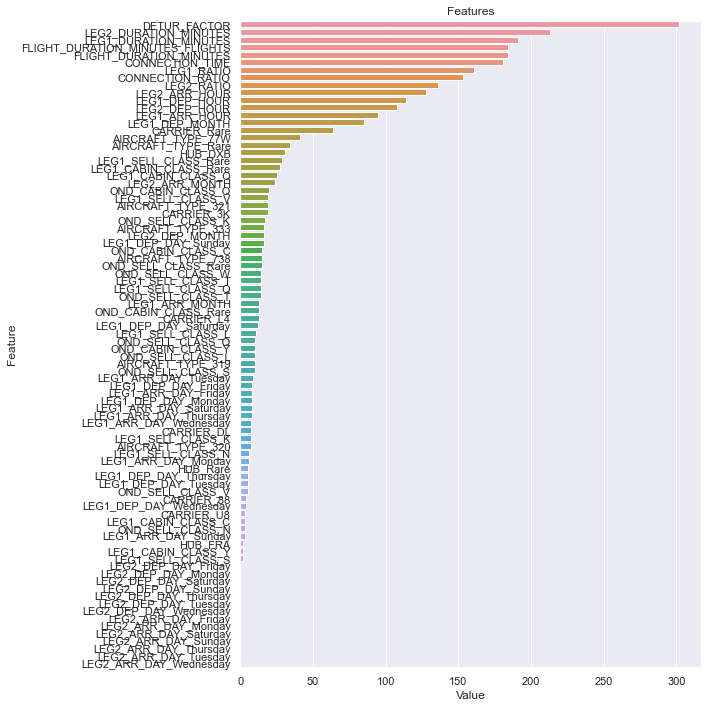

In [21]:
def plot_importance(model, features, num=len(X), save=False):

    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                         ascending=False)[0:num])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")

model = LGBMRegressor()
model.fit(X, y)

plot_importance(model, X)
